In [1]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Stopword dan stemmer
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
stemmer = StemmerFactory().create_stemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import pandas as pd

# Load data training dan testing
train_df = pd.read_csv('dataset_6.csv')        # Data latih
test_df = pd.read_csv('validation_data.csv')   # Data uji

# Tampilkan 5 baris pertama untuk memastikan
print(train_df.head())
print(test_df.head())

                       text  aspek sentiment  hotel  lokasi  kamar  pelayanan  \
0  shuttle gratis malioboro  harga  positive      0       0      0          0   
1  dapat gratis course golf  harga  positive      0       0      0          0   
2    gratis andong keliling  harga  positive      0       0      0          0   
3              sesuai harga  harga  positive      0       0      0          0   
4          harga terjangkau  harga  positive      0       0      0          0   

   makanan  harga  
0        0      1  
1        0      1  
2        0      1  
3        0      1  
4        0      1  
                                                text  hotel  lokasi  kamar  \
0  Harga di hotel ini sangat terjangkau, makanan ...      1       0      0   
1  Harga makanan di hotel ini sangat terjangkau, ...      0       0      0   
2  Meskipun harganya terjangkau, makanan di hotel...      0       0      1   
3  Hotel ini memiliki harga yang terjangkau, maka...      0       1      0   
4  

In [4]:
import re

# Fungsi untuk menghapus simbol, newline (\n, \t), dan tanda baca
def remove_symbols(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text)             # Hapus newline/tab
    text = re.sub(r'[^\w\s]', '', text)          # Hapus simbol & tanda baca
    return text
# Terapkan ke data training
train_df['symbol_punctuation_removal'] = train_df['text'].apply(remove_symbols)

# Terapkan ke data testing
test_df['symbol_punctuation_removal'] = test_df['text'].apply(remove_symbols)

# Lihat hasil awal
print(train_df[['text', 'symbol_punctuation_removal']].head())

                       text symbol_punctuation_removal
0  shuttle gratis malioboro   shuttle gratis malioboro
1  dapat gratis course golf   dapat gratis course golf
2    gratis andong keliling     gratis andong keliling
3              sesuai harga               sesuai harga
4          harga terjangkau           harga terjangkau


In [5]:
train_df['case_folding'] = train_df['symbol_punctuation_removal'].str.lower()
test_df['case_folding'] = test_df['symbol_punctuation_removal'].str.lower()

In [6]:
train_df['tokenized'] = train_df['case_folding'].apply(word_tokenize)
test_df['tokenized'] = test_df['case_folding'].apply(word_tokenize)

In [7]:
# Contoh dictionary normalisasi
normalization_dict = {
    'gk': 'nggak',
    'tdk': 'tidak',
    'bgt': 'banget',
    'dr': 'dari'
}

def normalize_tokens(tokens):
    return [normalization_dict.get(word, word) for word in tokens]

train_df['normalized'] = train_df['tokenized'].apply(normalize_tokens)
test_df['normalized'] = test_df['tokenized'].apply(normalize_tokens)

In [8]:
# Baca kamus normalisasi
df_kamus = pd.read_excel('kamus_normalisasi.xlsx')

# Buat dictionary hanya untuk kata yang memiliki 'Kata Baku'
kamus_normalisasi = df_kamus.dropna(subset=["Kata Baku"]).set_index("Kata")["Kata Baku"].to_dict()

# Buat set kata-kata yang ingin dihapus (karena 'Kata Baku'-nya kosong)
kata_dihapus = set(df_kamus[df_kamus["Kata Baku"].isnull()]["Kata"].tolist())

# Fungsi normalisasi
def normalisasi_kata(token_list, kamus, hapus_kata):
    return [kamus.get(kata, kata) for kata in token_list if kata not in hapus_kata]

# Terapkan ke data
# Untuk train_df
train_df['normalized_review'] = train_df['tokenized'].apply(lambda x: normalisasi_kata(x, kamus_normalisasi, kata_dihapus))

# Untuk test_df
test_df['normalized_review'] = test_df['tokenized'].apply(lambda x: normalisasi_kata(x, kamus_normalisasi, kata_dihapus))

In [9]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

train_df['stopwords_removed'] = train_df['tokenized'].apply(remove_stopwords)
test_df['stopwords_removed'] = test_df['tokenized'].apply(remove_stopwords)

In [10]:
def apply_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

train_df['stemmed'] = train_df['stopwords_removed'].apply(apply_stemming)
test_df['stemmed'] = test_df['stopwords_removed'].apply(apply_stemming)

In [11]:
train_df['clean_text'] = train_df['stemmed'].apply(lambda tokens: ' '.join(tokens))
test_df['clean_text'] = test_df['stemmed'].apply(lambda tokens: ' '.join(tokens))

In [12]:
pd.set_option('display.max_colwidth', None)
print(train_df[['text', 'symbol_punctuation_removal', 'case_folding', 'tokenized', 'stopwords_removed', 'stemmed', 'clean_text']].head())

                       text symbol_punctuation_removal  \
0  shuttle gratis malioboro   shuttle gratis malioboro   
1  dapat gratis course golf   dapat gratis course golf   
2    gratis andong keliling     gratis andong keliling   
3              sesuai harga               sesuai harga   
4          harga terjangkau           harga terjangkau   

               case_folding                      tokenized  \
0  shuttle gratis malioboro   [shuttle, gratis, malioboro]   
1  dapat gratis course golf  [dapat, gratis, course, golf]   
2    gratis andong keliling     [gratis, andong, keliling]   
3              sesuai harga                [sesuai, harga]   
4          harga terjangkau            [harga, terjangkau]   

              stopwords_removed                       stemmed  \
0  [shuttle, gratis, malioboro]  [shuttle, gratis, malioboro]   
1        [gratis, course, golf]        [gratis, course, golf]   
2    [gratis, andong, keliling]    [gratis, andong, keliling]   
3               [s

In [13]:
# Simpan ke file CSV (misalnya: hasil_preprocessing_train.csv)
train_df[['text', 
          'symbol_punctuation_removal', 
          'case_folding', 
          'tokenized', 
          'stopwords_removed', 
          'stemmed', 
          'clean_text']].to_csv('hasil_preprocessing_train.csv', index=False)

# Jika ingin menyimpan data test juga
test_df[['text', 
         'symbol_punctuation_removal', 
         'case_folding', 
         'tokenized', 
         'stopwords_removed', 
         'stemmed', 
         'clean_text']].to_csv('hasil_preprocessing_test.csv', index=False)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Ambil korpus dari kolom 'clean_text'
train_corpus = train_df['clean_text'].tolist()
test_corpus = test_df['clean_text'].tolist()

# Inisialisasi dan ekstraksi BoW hanya dari data training (penting!)
vectorizer = CountVectorizer(
    min_df=3,
    max_df=0.95,
    max_features=1500,
)

# Fit pada training data dan transform kedua set
train_bow_matrix = vectorizer.fit_transform(train_corpus)
test_bow_matrix = vectorizer.transform(test_corpus)

# Konversi ke array dan DataFrame
train_bow_array = train_bow_matrix.toarray()
test_bow_array = test_bow_matrix.toarray()

train_bow_df = pd.DataFrame(train_bow_array, columns=vectorizer.get_feature_names_out())
test_bow_df = pd.DataFrame(test_bow_array, columns=vectorizer.get_feature_names_out())

# Tambahkan kolom Review ID
train_bow_df.insert(0, 'Review', [f'R_bow_train_{i+1}' for i in range(len(train_bow_df))])
test_bow_df.insert(0, 'Review', [f'R_bow_test_{i+1}' for i in range(len(test_bow_df))])

# Tambahkan kolom Vector (berisi seluruh BoW row dalam bentuk list)
train_bow_df['Vector'] = train_bow_array.tolist()
test_bow_df['Vector'] = test_bow_array.tolist()

# Opsional: Tambahkan label jika perlu
train_bow_df['sentiment'] = train_df['sentiment'].values
test_bow_df['sentiment'] = test_df['sentiment'].values

# Tampilkan sebagian hasil
print(train_bow_df[['Review', 'Vector']].head())
print(test_bow_df[['Review', 'Vector']].head())

          Review  \
0  R_bow_train_1   
1  R_bow_train_2   
2  R_bow_train_3   
3  R_bow_train_4   
4  R_bow_train_5   

                                                                                                                                                                                                                                                                                                              Vector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [15]:
train_bow_df.to_csv('bow_train_df.csv', index=False)
test_bow_df.to_csv('bow_test_df.csv', index=False)

In [16]:
print("Kolom-kolom di train_df:")
print(train_df.columns.tolist())

print("\nKolom-kolom di test_df:")
print(test_df.columns.tolist())

Kolom-kolom di train_df:
['text', 'aspek', 'sentiment', 'hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga', 'symbol_punctuation_removal', 'case_folding', 'tokenized', 'normalized', 'normalized_review', 'stopwords_removed', 'stemmed', 'clean_text']

Kolom-kolom di test_df:
['text', 'hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga', 'sentiment', 'symbol_punctuation_removal', 'case_folding', 'tokenized', 'normalized', 'normalized_review', 'stopwords_removed', 'stemmed', 'clean_text']


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Gunakan matrix BoW dari sebelumnya
X_train = train_bow_array
X_test = test_bow_array

# Multi-label aspek
aspek_sentimen = ['hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga']
y_train = train_df[aspek_sentimen].values
y_test = test_df[aspek_sentimen].values

# Siapkan DataFrame untuk menyimpan hasil prediksi
prediksi_rf_df = test_df[['text']].copy()

# Loop untuk setiap aspek
for i, aspek in enumerate(aspek_sentimen):
    print(f"\n----- Random Forest for Aspect: {aspek.upper()} -----")

    y_train_aspek = y_train[:, i]
    y_test_aspek = y_test[:, i]

    # Model Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    )
    rf.fit(X_train, y_train_aspek)

    # Prediksi
    y_pred = rf.predict(X_test)

    # Simpan prediksi ke DataFrame
    prediksi_rf_df[f'pred_{aspek}'] = y_pred

    # Cetak evaluasi
    print(classification_report(y_test_aspek, y_pred, digits=3, zero_division=0))

# (Opsional) Tambahkan label asli untuk perbandingan
prediksi_rf_df = pd.concat([prediksi_rf_df, test_df[aspek_sentimen].add_prefix('true_')], axis=1)

# Simpan ke CSV
prediksi_rf_df.to_csv('hasil_prediksi_random_forest_evaluation.csv', index=False)
print("\n✅ Hasil prediksi Random Forest berhasil disimpan ke: hasil_prediksi_random_forest.csv")


----- Random Forest for Aspect: HOTEL -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        18
           0      0.467     1.000     0.636        56
           1      0.000     0.000     0.000        46

    accuracy                          0.467       120
   macro avg      0.156     0.333     0.212       120
weighted avg      0.218     0.467     0.297       120


----- Random Forest for Aspect: LOKASI -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        26
           0      0.747     1.000     0.855        62
           1      0.541     0.625     0.580        32

    accuracy                          0.683       120
   macro avg      0.429     0.542     0.478       120
weighted avg      0.530     0.683     0.596       120


----- Random Forest for Aspect: KAMAR -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000    

In [27]:
# Dictionary berisi akurasi dari masing-masing aspek
akurasi_per_aspek = {
    'hotel': 0.467,
    'lokasi': 0.683,
    'kamar': 0.608,
    'pelayanan': 0.592,
    'makanan': 0.558,
    'harga': 0.900
}

# Hitung rata-rata akurasi
average_accuracy = sum(akurasi_per_aspek.values()) / len(akurasi_per_aspek)

# Tampilkan hasil
print("Akurasi per aspek:")
for aspek, acc in akurasi_per_aspek.items():
    print(f"- {aspek.capitalize()}: {acc:.3f}")

print(f"\n📌 Rata-rata Akurasi RF: {average_accuracy:.3f} atau {average_accuracy*100:.2f}%")

Akurasi per aspek:
- Hotel: 0.467
- Lokasi: 0.683
- Kamar: 0.608
- Pelayanan: 0.592
- Makanan: 0.558
- Harga: 0.900

📌 Rata-rata Akurasi RF: 0.635 atau 63.47%


###  SVM 

In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Gunakan hasil BoW
X_train = train_bow_array
X_test = test_bow_array

# Multi-aspek
aspek_sentimen = ['hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga']
y_train = train_df[aspek_sentimen].values
y_test = test_df[aspek_sentimen].values

# Siapkan DataFrame untuk simpan prediksi
prediksi_svm_df = test_df[['text']].copy()

# Loop klasifikasi per aspek
for i, aspek in enumerate(aspek_sentimen):
    print(f"\n----- SVM for Aspect: {aspek.upper()} -----")

    y_train_aspek = y_train[:, i]
    y_test_aspek = y_test[:, i]

    # Model SVM
    svm = LinearSVC(class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train_aspek)

    # Prediksi
    y_pred = svm.predict(X_test)

    # Tambahkan hasil prediksi ke DataFrame
    prediksi_svm_df[f'pred_{aspek}'] = y_pred

    # Evaluasi
    print(classification_report(y_test_aspek, y_pred, digits=3, zero_division=0))

# Simpan hasil prediksi ke file CSV
prediksi_svm_df.to_csv('hasil_prediksi_svm.csv', index=False)
print("\n✅ Hasil prediksi SVM berhasil disimpan ke: hasil_prediksi_svm.csv")


----- SVM for Aspect: HOTEL -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        18
           0      0.467     1.000     0.636        56
           1      0.000     0.000     0.000        46

    accuracy                          0.467       120
   macro avg      0.156     0.333     0.212       120
weighted avg      0.218     0.467     0.297       120


----- SVM for Aspect: LOKASI -----
              precision    recall  f1-score   support

          -1      0.667     0.077     0.138        26
           0      0.620     1.000     0.765        62
           1      0.765     0.406     0.531        32

    accuracy                          0.642       120
   macro avg      0.684     0.494     0.478       120
weighted avg      0.669     0.642     0.567       120


----- SVM for Aspect: KAMAR -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        33
           0      0.546

In [28]:
# Dictionary berisi akurasi dari masing-masing aspek
akurasi_per_aspek = {
    'hotel': 0.467,
    'lokasi': 0.642,
    'kamar': 0.550,
    'pelayanan': 0.592,
    'makanan': 0.541,
    'harga': 0.700
}

# Hitung rata-rata akurasi
average_accuracy = sum(akurasi_per_aspek.values()) / len(akurasi_per_aspek)

# Tampilkan hasil
print("Akurasi per aspek:")
for aspek, acc in akurasi_per_aspek.items():
    print(f"- {aspek.capitalize()}: {acc:.3f}")

print(f"\n📌 Rata-rata Akurasi SVM: {average_accuracy:.3f} atau {average_accuracy*100:.2f}%")

Akurasi per aspek:
- Hotel: 0.467
- Lokasi: 0.642
- Kamar: 0.550
- Pelayanan: 0.592
- Makanan: 0.541
- Harga: 0.700

📌 Rata-rata Akurasi SVM: 0.582 atau 58.20%


### Multinomial Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd

# Gunakan hasil BoW
X_train = train_bow_array
X_test = test_bow_array

# Kolom aspek
aspek_sentimen = ['hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga']

# Ambil label
y_train = train_df[aspek_sentimen].values
y_test = test_df[aspek_sentimen].values

# DataFrame untuk menyimpan prediksi
prediksi_nb_df = test_df[['text']].copy()

# Loop tiap aspek
for i, aspek in enumerate(aspek_sentimen):
    print(f"\n----- Multinomial Naive Bayes for Aspect: {aspek.upper()} -----")

    y_train_aspek = y_train[:, i]
    y_test_aspek = y_test[:, i]

    # Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train_aspek)

    # Model Naive Bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_resampled, y_train_resampled)

    # Prediksi
    y_pred = mnb.predict(X_test)

    # Simpan prediksi
    prediksi_nb_df[f'pred_{aspek}'] = y_pred

    # Cetak evaluasi
    print(classification_report(y_test_aspek, y_pred, digits=3, zero_division=0))

# Tambahkan label asli untuk perbandingan
prediksi_nb_df = pd.concat([prediksi_nb_df, test_df[aspek_sentimen].add_prefix('true_')], axis=1)

# Simpan ke CSV
prediksi_nb_df.to_csv('hasil_prediksi_naive_bayes.csv', index=False)
print("\n✅ Hasil prediksi Multinomial Naive Bayes berhasil disimpan ke: hasil_prediksi_naive_bayes.csv")


----- Multinomial Naive Bayes for Aspect: HOTEL -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        18
           0      0.500     1.000     0.667        56
           1      0.625     0.109     0.185        46

    accuracy                          0.508       120
   macro avg      0.375     0.370     0.284       120
weighted avg      0.473     0.508     0.382       120


----- Multinomial Naive Bayes for Aspect: LOKASI -----
              precision    recall  f1-score   support

          -1      1.000     0.038     0.074        26
           0      0.674     1.000     0.805        62
           1      0.778     0.656     0.712        32

    accuracy                          0.700       120
   macro avg      0.817     0.565     0.530       120
weighted avg      0.772     0.700     0.622       120


----- Multinomial Naive Bayes for Aspect: KAMAR -----
              precision    recall  f1-score   support

          -1     

In [29]:
# Dictionary berisi akurasi dari masing-masing aspek
akurasi_per_aspek = {
    'hotel': 0.508,
    'lokasi': 0.700,
    'kamar': 0.583,
    'pelayanan': 0.550,
    'makanan': 0.600,
    'harga': 0.808
}

# Hitung rata-rata akurasi
average_accuracy = sum(akurasi_per_aspek.values()) / len(akurasi_per_aspek)

# Tampilkan hasil
print("Akurasi per aspek:")
for aspek, acc in akurasi_per_aspek.items():
    print(f"- {aspek.capitalize()}: {acc:.3f}")

print(f"\n📌 Rata-rata Akurasi Naive Bayes: {average_accuracy:.3f} atau {average_accuracy*100:.2f}%")

Akurasi per aspek:
- Hotel: 0.508
- Lokasi: 0.700
- Kamar: 0.583
- Pelayanan: 0.550
- Makanan: 0.600
- Harga: 0.808

📌 Rata-rata Akurasi Naive Bayes: 0.625 atau 62.48%


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# ✅ Gunakan hasil BoW
X_train = train_bow_array
X_test = test_bow_array

# ✅ Label multi-aspek
aspek_sentimen = ['hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga']
y_train = train_df[aspek_sentimen].values
y_test = test_df[aspek_sentimen].values

# Nilai k untuk K-NN
k = 5

# DataFrame untuk menyimpan hasil prediksi
prediksi_knn_df = test_df[['text']].copy()

# Loop tiap aspek
for i, aspek in enumerate(aspek_sentimen):
    print(f"\n----- K-NN for Aspect: {aspek.upper()} -----")

    y_train_aspek = y_train[:, i]
    y_test_aspek = y_test[:, i]

    # Inisialisasi dan training
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric='minkowski',
        weights='distance'
    )
    knn.fit(X_train, y_train_aspek)

    # Prediksi
    y_pred = knn.predict(X_test)

    # Simpan prediksi ke kolom
    prediksi_knn_df[f'pred_{aspek}'] = y_pred

    # Cetak evaluasi
    print(classification_report(y_test_aspek, y_pred, digits=3, zero_division=0))

# Tambahkan kolom label asli
prediksi_knn_df = pd.concat([prediksi_knn_df, test_df[aspek_sentimen].add_prefix('true_')], axis=1)

# Simpan ke CSV
prediksi_knn_df.to_csv('hasil_prediksi_knn.csv', index=False)
print("\n✅ Hasil prediksi K-NN berhasil disimpan ke: hasil_prediksi_knn.csv")


----- K-NN for Aspect: HOTEL -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        18
           0      0.467     1.000     0.636        56
           1      0.000     0.000     0.000        46

    accuracy                          0.467       120
   macro avg      0.156     0.333     0.212       120
weighted avg      0.218     0.467     0.297       120


----- K-NN for Aspect: LOKASI -----
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000        26
           0      0.590     1.000     0.743        62
           1      0.667     0.312     0.426        32

    accuracy                          0.600       120
   macro avg      0.419     0.438     0.389       120
weighted avg      0.483     0.600     0.497       120


----- K-NN for Aspect: KAMAR -----
              precision    recall  f1-score   support

          -1      1.000     0.030     0.059        33
           0      0.

In [30]:
# Dictionary berisi akurasi dari masing-masing aspek
akurasi_per_aspek = {
    'hotel': 0.467,
    'lokasi': 0.600,
    'kamar': 0.600,
    'pelayanan': 0.658,
    'makanan': 0.583,
    'harga': 0.642
}

# Hitung rata-rata akurasi
average_accuracy = sum(akurasi_per_aspek.values()) / len(akurasi_per_aspek)

# Tampilkan hasil
print("Akurasi per aspek:")
for aspek, acc in akurasi_per_aspek.items():
    print(f"- {aspek.capitalize()}: {acc:.3f}")

print(f"\n📌 Rata-rata Akurasi K-NN: {average_accuracy:.3f} atau {average_accuracy*100:.2f}%")

Akurasi per aspek:
- Hotel: 0.467
- Lokasi: 0.600
- Kamar: 0.600
- Pelayanan: 0.658
- Makanan: 0.583
- Harga: 0.642

📌 Rata-rata Akurasi K-NN: 0.592 atau 59.17%


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16652\421473185.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


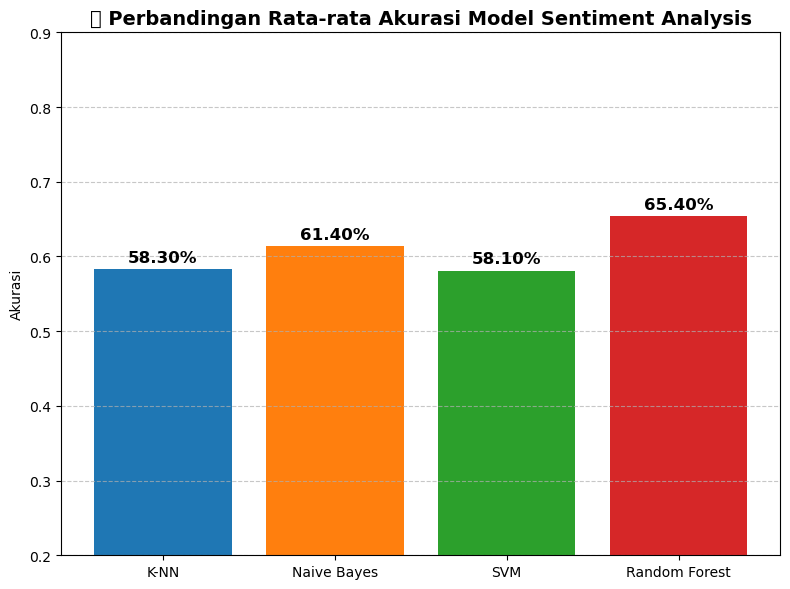

In [25]:
import matplotlib.pyplot as plt

# Data rata-rata akurasi model
model_names = ['K-NN', 'Naive Bayes', 'SVM', 'Random Forest']
accuracies = [0.583, 0.614, 0.581, 0.654]

# Warna dan label
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=colors)

# Tambahkan nilai akurasi di atas setiap bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{acc*100:.2f}%', 
             ha='center', fontsize=12, fontweight='bold')

# Styling
plt.title('📊 Perbandingan Rata-rata Akurasi Model Sentiment Analysis', fontsize=14, weight='bold')
plt.ylabel('Akurasi')
plt.ylim(0.20, 0.90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

### This is just prediction

In [26]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Gunakan matrix BoW dari sebelumnya
X_train = train_bow_array         # BoW untuk data training
X_test = test_bow_array           # BoW untuk data baru yang ingin diprediksi

# Multi-label aspek
aspek_sentimen = ['hotel', 'lokasi', 'kamar', 'pelayanan', 'makanan', 'harga']
y_train = train_df[aspek_sentimen].values  # label training

# Siapkan DataFrame untuk menyimpan hasil prediksi
prediksi_rf_df = test_df[['text']].copy()  # hanya kolom 'text'

# Loop untuk setiap aspek
for i, aspek in enumerate(aspek_sentimen):
    print(f"Training dan prediksi aspek: {aspek.upper()}")

    y_train_aspek = y_train[:, i]

    # Model Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    )
    rf.fit(X_train, y_train_aspek)

    # Prediksi aspek untuk data baru
    y_pred = rf.predict(X_test)

    # Simpan hasil prediksi ke DataFrame
    prediksi_rf_df[f'pred_{aspek}'] = y_pred

# Simpan ke CSV
prediksi_rf_df.to_csv('hasil_prediksi_random_forest.csv', index=False)
print("\n✅ Prediksi berhasil disimpan ke: hasil_prediksi_random_forest.csv")

Training dan prediksi aspek: HOTEL
Training dan prediksi aspek: LOKASI
Training dan prediksi aspek: KAMAR
Training dan prediksi aspek: PELAYANAN
Training dan prediksi aspek: MAKANAN
Training dan prediksi aspek: HARGA

✅ Prediksi berhasil disimpan ke: hasil_prediksi_random_forest.csv
